<a href="https://colab.research.google.com/github/farah-salama/autonomous-car/blob/main/car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/farah-salama/autonomous-car.git

Cloning into 'autonomous-car'...
remote: Enumerating objects: 18653, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 18653 (delta 0), reused 3 (delta 0), pack-reused 18647
Receiving objects: 100% (18653/18653), 279.75 MiB | 16.31 MiB/s, done.
Updating files: 100% (18652/18652), done.


In [ ]:
!ls autonomous-car

car.ipynb  driving_log.csv  driving_log_test.csv  IMG  IMG_test  README.md


In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import ntpath
import random
from sklearn.utils import shuffle
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
datadir = 'autonomous-car'
df = pd.read_csv(os.path.join(datadir, 'driving_log.csv'))
df_test = pd.read_csv(os.path.join(datadir, 'driving_log_test.csv'))

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
df['center'] = df['center'].apply(path_leaf)
df['left'] = df['left'].apply(path_leaf)
df['right'] = df['right'].apply(path_leaf)
df_test['center'] = df_test['center'].apply(path_leaf)
df_test['left'] = df_test['left'].apply(path_leaf)
df_test['right'] = df_test['right'].apply(path_leaf)

In [ ]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_09_20_22_09_58_450.jpg,left_2023_09_20_22_09_58_450.jpg,right_2023_09_20_22_09_58_450.jpg,0.0,0.0,0,3.630000e-06
1,center_2023_09_20_22_09_58_523.jpg,left_2023_09_20_22_09_58_523.jpg,right_2023_09_20_22_09_58_523.jpg,0.0,0.0,0,2.460000e-06
2,center_2023_09_20_22_09_58_594.jpg,left_2023_09_20_22_09_58_594.jpg,right_2023_09_20_22_09_58_594.jpg,0.0,0.0,0,1.710000e-07
3,center_2023_09_20_22_09_58_662.jpg,left_2023_09_20_22_09_58_662.jpg,right_2023_09_20_22_09_58_662.jpg,0.0,0.0,0,1.170000e-06
4,center_2023_09_20_22_09_58_730.jpg,left_2023_09_20_22_09_58_730.jpg,right_2023_09_20_22_09_58_730.jpg,0.0,0.0,0,1.020000e-06


In [ ]:
df_test.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_09_20_22_26_55_824.jpg,left_2023_09_20_22_26_55_824.jpg,right_2023_09_20_22_26_55_824.jpg,0.0,0.0,0,0.000011
1,center_2023_09_20_22_26_55_891.jpg,left_2023_09_20_22_26_55_891.jpg,right_2023_09_20_22_26_55_891.jpg,0.0,0.0,0,0.000003
2,center_2023_09_20_22_26_55_966.jpg,left_2023_09_20_22_26_55_966.jpg,right_2023_09_20_22_26_55_966.jpg,0.0,0.0,0,0.000011
3,center_2023_09_20_22_26_56_036.jpg,left_2023_09_20_22_26_56_036.jpg,right_2023_09_20_22_26_56_036.jpg,0.0,0.0,0,0.000015
4,center_2023_09_20_22_26_56_104.jpg,left_2023_09_20_22_26_56_104.jpg,right_2023_09_20_22_26_56_104.jpg,0.0,0.0,0,0.000005


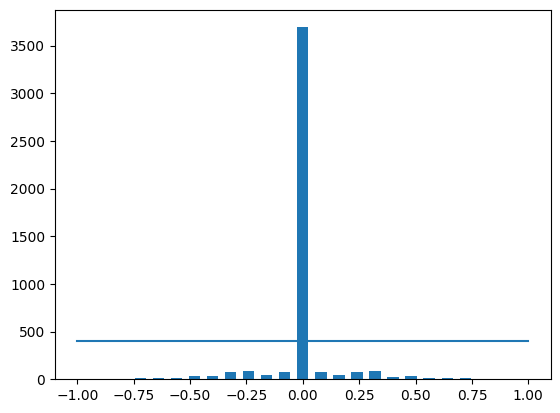

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df['steering'])):
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

removed: 3292
remaining: 1204


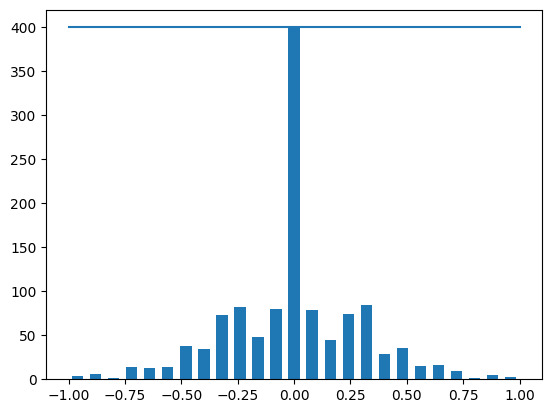

In [ ]:
hist, _ = np.histogram(df['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import v2
import cv2

In [ ]:
#transform = transforms.Compose(
 #   [transforms.ToTensor(),
  #   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])'''

In [ ]:
import matplotlib.image as npimg
def img_preprocess(img):
  #img = npimg.imread(img)

  ## Crop image to remove unnecessary features
  #img = img[60:135, :, :]

  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)

  ## Decrease size for easier processing
  #img = cv2.resize(img, (80, 40))

  ## Normalize values
  img = img / 255
  return img

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = npimg.imread(img_path)
        steering = self.img_labels.iloc[idx, 3]
        image = img_preprocess(image)
        if self.transform:
            image = transform(image)
        return image, steering

In [ ]:
train_data = CustomImageDataset(df,'autonomous-car/IMG', transform = False)
test_data = CustomImageDataset(df_test, 'autonomous-car/IMG_test', transform=False)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 160, 320, 3])
steerings batch shape: torch.Size([64])


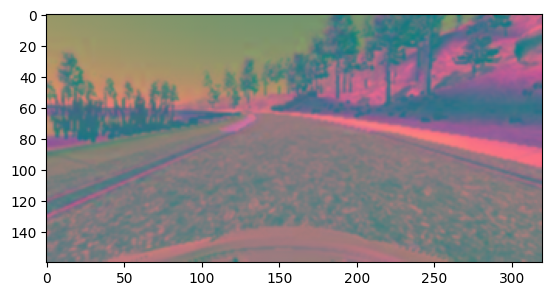

Steering: 0.0


In [ ]:
train_features, train_steerings = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"steerings batch shape: {train_steerings.size()}")
img = train_features[0].squeeze()
plt.imshow(img)
steering = train_steerings[0]
plt.show()
print(f"Steering: {steering}")

In [ ]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 =nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 =nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(77,10)
        #self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
       x = self.conv1(x)
       x = self.relu1(x)
       x = self.pool(x)
       x = self.conv2(x)
       x = self.relu2(x)
       x = self.pool(x)
       x = self.fc1(x)
       x = self.relu1(x)
       #x = self.fc2(x)
       #x = self.relu1(x)
       x = self.fc3(x)
       return x

net = Net()

In [ ]:
num_epochs = 5
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
import gc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
gc.collect()
net.to(device)
for epoch in range(num_epochs): # Loop over the epochs
    running_loss = 0.0 # Initialize the running loss
    for i, data in enumerate(train_dataloader): # Loop over the batches
        inputs, labels = data # Get the inputs and labels from the data loader
        optimizer.zero_grad() # Zero the parameter gradients
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = inputs.to(torch.float32).to(device)
        outputs = net(inputs) # Forward pass: compute the outputs from the inputs
        labels = labels.to(torch.float32)
        labels =  labels.to(device)
        loss = criterion(outputs, labels) # Compute the loss from the outputs and labels
        loss.backward() # Backward pass: compute the gradients from the loss

        optimizer.step() # Update the parameters with the gradients

        running_loss += loss.item() # Accumulate the running loss
        if i % 19 == 18: # Print the statistics every 2000 batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 19))
            running_loss = 0.0

print('Finished Training')

[1,    19] loss: 0.121
[2,    19] loss: 0.092
[3,    19] loss: 0.091
[4,    19] loss: 0.092
[5,    19] loss: 0.090
Finished Training


In [ ]:
net.eval()
with torch.no_grad(): # Loop over the epochs
    running_loss = 0.0 # Initialize the running loss
    total = 0
    for i, data in enumerate(test_dataloader): # Loop over the batches
        inputs, labels = data # Get the inputs and labels from the data loader
        optimizer.zero_grad() # Zero the parameter gradients
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = inputs.to(torch.float32).to(device)
        outputs = net(inputs) # Forward pass: compute the outputs from the inputs
        labels = labels.to(torch.float32)
        labels =  labels.to(device)
        loss = criterion(outputs, labels) # Compute the loss from the outputs and labels
        running_loss += loss.item() # Accumulate the running loss
        total = i+1

    print('Avg loss: %.3f' % (running_loss / total))

Avg loss: 0.017


In [ ]:
torch.save(net, 'model.pth')